### 0. 기본 세팅

In [ ]:
# 폰트 설정
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [84]:
!pip install scikit-learn-extra

     |████████████████████████████████| 1.7 MB 6.5 MB/s 


In [202]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from sklearn import metrics
from sklearn.decomposition import PCA

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import scipy.cluster.hierarchy as shc

import plotly.graph_objects as go
import plotly.offline as pyo
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rc('font', family='NanumBarunGothic') 

import folium
from folium.plugins import MarkerCluster, FeatureGroupSubGroup
from folium.features import DivIcon

import os
import json
import warnings
warnings.filterwarnings('ignore')

### 1. 데이터 병합, 전처리

In [108]:
peo1 = pd.read_csv('/content/drive/Shareddrives/강서구/using_data/생활인구.csv')
peo2 = pd.read_csv('/content/drive/Shareddrives/강서구/using_data/주민등록.csv')
sub = pd.read_csv('/content/drive/Shareddrives/강서구/using_data/지하철_승하차.csv')
apt = pd.read_csv('/content/drive/Shareddrives/강서구/using_data/공동주택.csv')
store = pd.read_csv('/content/drive/Shareddrives/강서구/using_data/상권세분화.csv')
trade = pd.read_csv('/content/drive/Shareddrives/강서구/using_data/중고거래.csv')
df = [peo1, peo2, sub, apt, store, trade]

In [109]:
# 병합, 결측치 대체
gs_df = peo1
for data in df[1:]:
  data.columns = ['동'] + list(data.columns[1:])
  gs_df = pd.merge(gs_df, data, how='outer', on='동')
gs_df = gs_df.fillna(0)
gs_df.head()

,동,10-60세_생활,10-60세_주민,승하차수,단독주택,다가구주택,영업겸용,아파트,연립주택,다세대주택,...,고밀주거지역,공업중심지역,수계,산,일반상업지,학교시설,오피스가,중밀주거지역,주택오피스가,중고거래횟수
0,가양1동,38409.806794,27360.0,405527.0,14,42,28,6733,359,713,...,95,5,4,0,12,4,14,11,1,1404
1,가양2동,9284.112080,7569.0,0.0,0,0,0,7082,0,0,...,49,0,2,0,3,3,1,0,1,852
2,가양3동,7418.582583,9059.0,0.0,0,0,0,7454,0,0,...,51,2,1,0,3,4,2,0,0,496
3,공항동,24540.875097,20919.0,867366.0,152,822,355,3044,133,3319,...,20,0,1,0,11,5,1,97,4,1633
4,등촌1동,17957.376831,18796.0,303483.0,16,109,58,4633,143,1382,...,46,0,1,0,15,1,7,20,4,1342


* 변수 선택
  * 주민등록, 생활인구 : 주 이용 대상인 10-60세만 사용
  * 공동주택 : 영업겸용, 비거주용건물내주택은 기타 항목으로 묶음
  * 상권세분화 : 주택 관련 항목 제거하고 상권 관련 항목만 사용

In [110]:
# 상권세분화 항목 축소
gs_df['기타주택'] = gs_df['영업겸용'] + gs_df['비거주용건물내주택']
gs_df = gs_df[['동', '10-60세_생활', '10-60세_주민', 
               '승하차수', '단독주택', '다가구주택', '아파트', '연립주택', '다세대주택', 
               '학교시설', '오피스가', '주택상업지', '주택오피스가', '복합상업지', 
               '중고거래횟수']]
gs_df.head()

,동,10-60세_생활,10-60세_주민,승하차수,단독주택,다가구주택,아파트,연립주택,다세대주택,학교시설,오피스가,주택상업지,주택오피스가,복합상업지,중고거래횟수
0,가양1동,38409.806794,27360.0,405527.0,14,42,6733,359,713,4,14,10,1,8,1404
1,가양2동,9284.112080,7569.0,0.0,0,0,7082,0,0,3,1,2,1,1,852
2,가양3동,7418.582583,9059.0,0.0,0,0,7454,0,0,4,2,6,0,0,496
3,공항동,24540.875097,20919.0,867366.0,152,822,3044,133,3319,5,1,14,4,7,1633
4,등촌1동,17957.376831,18796.0,303483.0,16,109,4633,143,1382,1,7,9,4,10,1342


In [111]:
gs_df.to_csv('/content/drive/Shareddrives/강서구/using_data/최종데이터.csv', index=False) # 스케일링 전

In [112]:
# MinMax 스케일링
dong = gs_df['동']
cols = gs_df.columns
gs_df_tmp = gs_df.drop(['동'], axis=1)

scaler = MinMaxScaler()
gs_df_tmp = scaler.fit_transform(gs_df_tmp)
gs_df_scaled = pd.DataFrame(data = gs_df_tmp)

gs_df_sc = pd.concat([dong, gs_df_scaled], axis=1)
gs_df_sc.columns = cols
gs_df_sc.describe()

,10-60세_생활,10-60세_주민,승하차수,단독주택,다가구주택,아파트,연립주택,다세대주택,학교시설,오피스가,주택상업지,주택오피스가,복합상업지,중고거래횟수
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,0.378933,0.420507,0.175542,0.181509,0.413839,0.413186,0.346387,0.293970,0.450000,0.300000,0.271622,0.325000,0.403333,0.372293
std,0.273366,0.272316,0.283730,0.237012,0.336909,0.301391,0.289542,0.282641,0.282144,0.274791,0.237805,0.308730,0.288959,0.282738
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.134540,0.222177,0.000000,0.025888,0.097774,0.202660,0.151734,0.084427,0.343750,0.142857,0.148649,0.071429,0.116667,0.171367
50%,0.375404,0.362911,0.000000,0.105030,0.434416,0.383929,0.270954,0.228208,0.375000,0.214286,0.189189,0.285714,0.400000,0.336764
75%,0.534603,0.636810,0.211733,0.240385,0.617028,0.667117,0.486272,0.356151,0.625000,0.375000,0.344595,0.357143,0.616667,0.536846
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


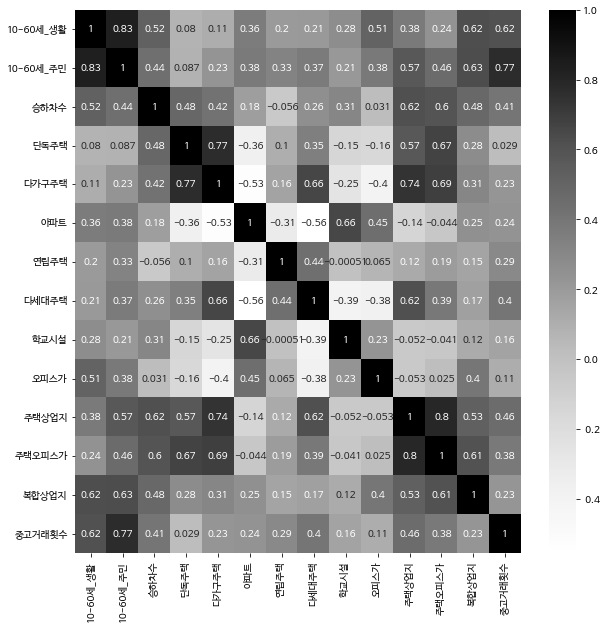

In [113]:
# 상관관계 분석
plt.figure(figsize=(10,10),facecolor="white")
ax = sns.heatmap(gs_df.corr(), annot=True, cmap='Greys')
plt.show()

In [114]:
gs_df_sc.to_csv('/content/drive/Shareddrives/강서구/using_data/최종데이터_스케일.csv', index=False) # 스케일링 후

* 군집화 후 각 군집별로 지도 위에 시각화
* 각 지표값별 상태(?) 확인

### 2. K-means Clustering

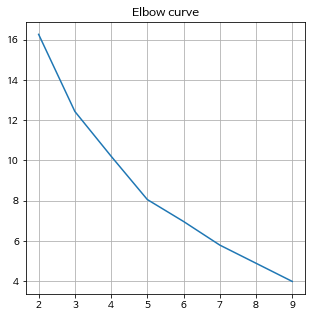

In [176]:
# elbow chart
distortions = []
gs_df_cl = gs_df_sc.drop(['동'], axis=1)

for k in range(2, 10):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(gs_df_cl)
    distortions.append(kmeans.inertia_)

fig = plt.figure(figsize=(5, 5))
plt.plot(range(2, 10), distortions)
plt.grid(True)
plt.title('Elbow curve')
plt.show()

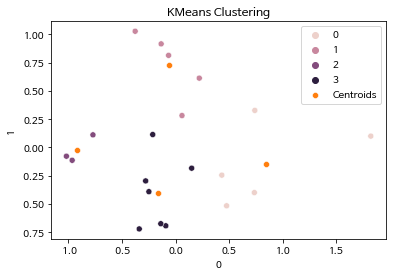

Silhouette Coefficient: 0.4391
Davies Bouldin Index: 0.6995


In [177]:
pca = PCA(n_components=2)
reduced_df = pca.fit_transform(gs_df_cl)
reduced_df = pd.DataFrame(reduced_df)

km = KMeans(n_clusters=4, init='k-means++')
cluster = km.fit(reduced_df)
cluster_id = pd.DataFrame(cluster.labels_)

d1 = pd.concat([reduced_df, cluster_id], axis=1)
d1.columns = [0, 1, "cluster"]

sns.scatterplot(d1[0], d1[1], hue = d1['cluster'], legend="full")
sns.scatterplot(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1], label = 'Centroids')
plt.title("KMeans Clustering")
plt.legend()
plt.show()

print('Silhouette Coefficient: {:.4f}'.format(metrics.silhouette_score(d1.iloc[:,:-1], d1['cluster'])))
print('Davies Bouldin Index: {:.4f}'.format(metrics.davies_bouldin_score(d1.iloc[:,:-1], d1['cluster'])))

In [181]:
# 군집화 결과 지도 시각화
m = folium.Map(location=[37.56,126.83], zoom_start=13, tiles='cartodbpositron')
os.chdir('/content/drive/Shareddrives/강서구/220311 EDA/')
geo_path = 'gangseo.json'
gangseo_geo = json.load(open(geo_path, encoding='utf-8'))

map_mean_3 = pd.concat([gs_df_sc['동'], cluster_id], axis=1)

f1 = folium.Choropleth(geo_data=gangseo_geo,
                    data=map_mean_3, 
                    columns = map_mean_3.columns,
                    key_on='feature.properties.name',
                    fill_color='YlGn',
                    fill_opacity=0.7,
                    line_opacity=0.3,
                    legend_name="ward 기법 소속 군집",
                    name = 'ward 기법 소속 군집',
                    highlight=True).add_to(m)

folium.LayerControl(collapsed=False).add_to(m)
f1.geojson.add_child(folium.features.GeoJsonTooltip(['name'], labels=False))
m

In [126]:
def Kmeans(k):
  model = KMeans(n_clusters = k, random_state = 10)
  gs_df_cl = gs_df_sc.drop(['동'], axis=1)
  model.fit(gs_df_cl)

  gs_df_mean = gs_df_sc.copy(deep=True)
  gs_df_mean['cluster'] = model.fit_predict(gs_df_cl)
  return gs_df_mean

In [165]:
gs_df_sc = pd.read_csv('/content/drive/Shareddrives/강서구/using_data/최종데이터_스케일.csv')

mean_3 = Kmeans(3)
mean_4 = Kmeans(4)
mean_5 = Kmeans(5)

In [164]:
# 군집 개수 3개일 때 시각화
cluster = list(mean_3['cluster'])


fig = go.Figure(
    data = [
            go.Scatterpolar(r = mean_3['10-60세_생활'].tolist(), theta=cluster, fill='toself', name='10-60세_생활'),
            go.Scatterpolar(r = mean_3['10-60세_주민'].tolist(), theta=cluster, fill='toself', name='10-60세_주민'),
    ],
    layout=go.Layout(
        title=go.layout.Title(text='Grade'),
        polar={'radialaxis': {'visible': True}},
        showlegend=True
    )
)

pyo.plot(fig)

'temp-plot.html'

### 3. K-medoids Clustering

In [158]:
def Kmedoids(k):
  gs_df_cl = gs_df_sc.drop(['동'], axis=1)
  kmedoids = KMedoids(n_clusters=k, random_state=0).fit(gs_df_cl)

  gs_df_med = gs_df_sc.copy(deep=True)
  gs_df_med['cluster'] = kmedoids.labels_
  return gs_df_med

In [159]:
gs_df_med_3 = Kmedoids(3)
gs_df_med_4 = Kmedoids(4)
gs_df_med_5 = Kmedoids(5)

### 4. 계층적 군집분석

데이터프레임 정리
* gs_df_sc : 스케일링한 원본
* reduced_df_x : 동만 뺀 gs_df_sc
* gs_df_cl : 클러스터 결과 합친 gs_df_sc

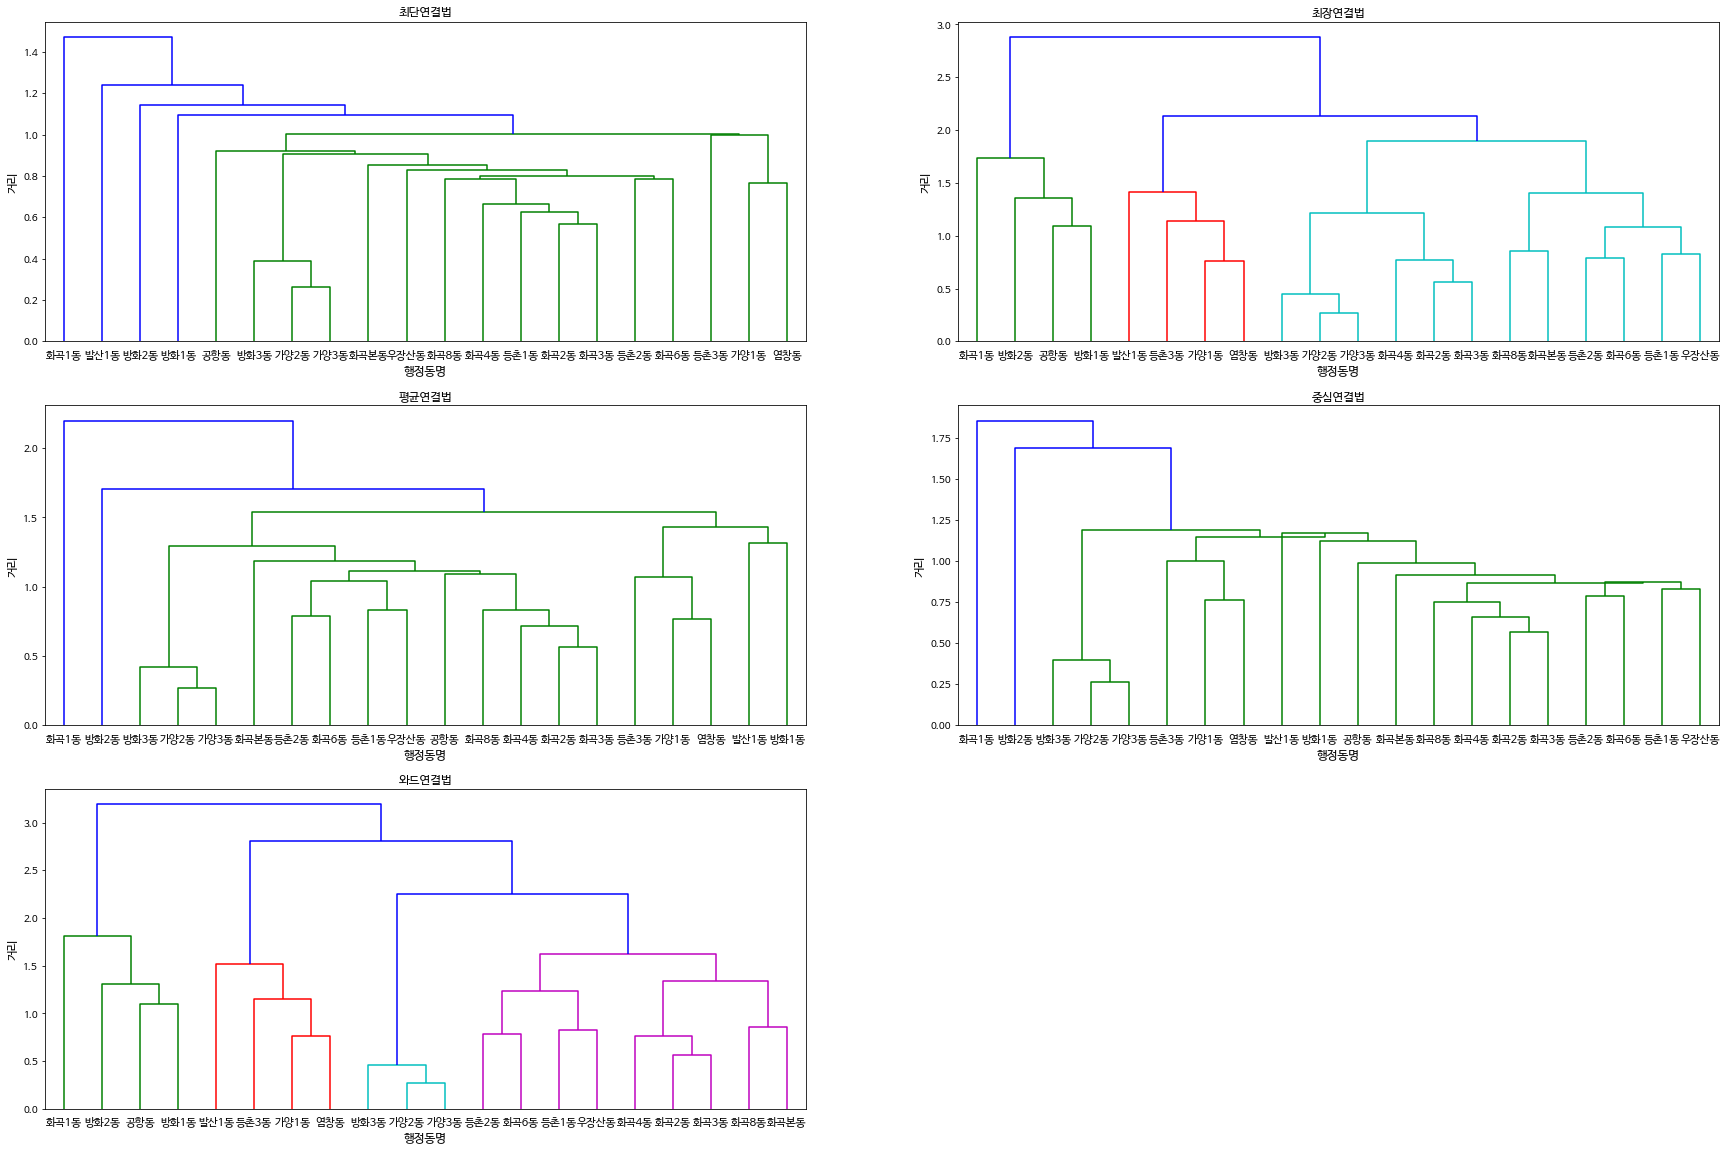

In [213]:
reduced_df_x = gs_df_sc.drop(['동'], axis = 1)

single_method = linkage(reduced_df_x, method = "single", metric = "euclidean") # 연속형변수, 스케일링을 했으므로 유클리드 거리 사용
complete_method = linkage(reduced_df_x, method = "complete", metric = "euclidean")
average_method = linkage(reduced_df_x, method = "average", metric = "euclidean")
median_method = linkage(reduced_df_x, method = "median", metric = "euclidean")
ward_method = linkage(reduced_df_x, method = "ward", metric = "euclidean")

method = [single_method, complete_method, average_method, median_method, ward_method]
label = ['최단연결법', '최장연결법','평균연결법','중심연결법','와드연결법']

plt.figure(figsize=(30, 20), facecolor="white")
for i in range(0, 5):
    ax = plt.subplot(3,2,i+1)
    dendrogram(method[i], labels = gs_df_sc["동"].values, leaf_font_size = 11)
    plt.title(label[i], fontsize=12)
    plt.xlabel("행정동명", fontsize=12)
    plt.ylabel("거리", fontsize=12)
plt.show()

* 최장연결법의 3개 분류가 적당한것으로 파악됨

In [214]:
# 최장연결법
ward_clusters = pd.DataFrame(shc.fcluster(shc.linkage(reduced_df_x, method='complete'), 2.0, criterion='distance'))
gs_df_cl = gs_df_sc.copy(deep=True)
gs_df_cl['cluster'] = ward_clusters
gs_df_cl.head()

,동,10-60세_생활,10-60세_주민,승하차수,단독주택,다가구주택,아파트,연립주택,다세대주택,학교시설,오피스가,주택상업지,주택오피스가,복합상업지,중고거래횟수,cluster
0,가양1동,1.000000,0.670904,0.165278,0.041420,0.050542,0.493861,0.518786,0.064073,0.500,1.000000,0.216216,0.071429,0.533333,0.377933,2
1,가양2동,0.060195,0.000000,0.000000,0.000000,0.000000,0.520812,0.000000,0.000000,0.375,0.071429,0.000000,0.071429,0.066667,0.150679,3
2,가양3동,0.000000,0.050510,0.000000,0.000000,0.000000,0.549541,0.000000,0.000000,0.500,0.142857,0.108108,0.000000,0.000000,0.004117,3
3,공항동,0.552488,0.452558,0.353507,0.449704,0.989170,0.208974,0.192197,0.298257,0.625,0.071429,0.324324,0.285714,0.466667,0.472211,1
4,등촌1동,0.340057,0.380589,0.123689,0.047337,0.131167,0.331686,0.206647,0.124191,0.125,0.500000,0.189189,0.285714,0.666667,0.352408,3


In [215]:
gs_df_cl.groupby('cluster').mean()[['10-60세_생활', '10-60세_주민', '중고거래횟수']]

,10-60세_생활,10-60세_주민,중고거래횟수
cluster,,,
1,0.549233,0.609021,0.539522
2,0.683142,0.616724,0.556608
3,0.220763,0.292264,0.255112


In [217]:
cluster_2 = list(set(gs_df_cl[gs_df_cl['cluster']==2]['동']))
cluster_2

['등촌3동', '가양1동', '발산1동', '염창동']

* 주요 변수(생활인구, 주민등록, 중고거래횟수) 비교 결과, 2번 클러스터(등촌3동, 가양1동, 발산1동, 염창동)를 주요 설치 지역으로 선택